# Practical work 4: Frequency filtering, color

In [1]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift, ifftshift
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()



## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

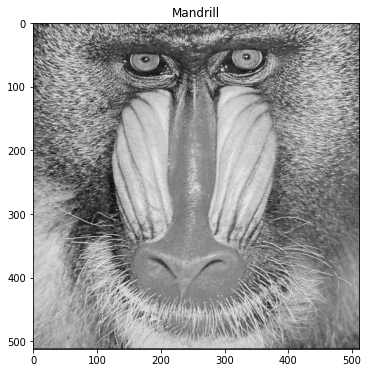

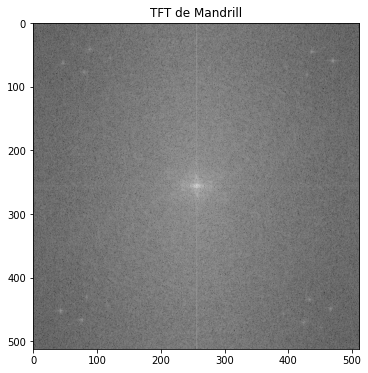

In [2]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fft2(I)

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return np.abs(fftshift(If))

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return np.log(toVisualizeFT(If)+1)

mandrill= np.array(Image.open("img/mandrill.png"))
lena= np.array(Image.open("img/lena.jpg"))

imshow(mandrill,"Mandrill")
imshow(toVisualizeLogFT(computeFT(mandrill)),"TFT de Mandrill")

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

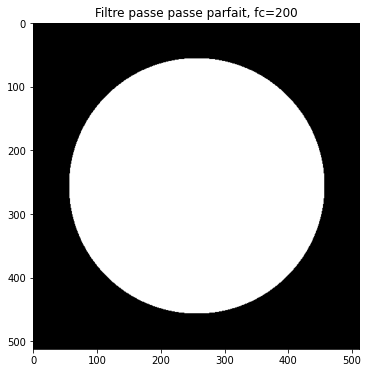

In [3]:
def idealLowPassFilter(n,m,fc):
    """int*int*int-> Array
    Retourne un filtre passe bas idéal"
    """
    cn = np.floor(n/2)
    cm = np.floor(m/2)
    F = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if np.sqrt((cn-i)**2 + (cm-j)**2 )<fc:
                F[i,j] = 1
            else:
                F[i,j] = 0
    return F

imshow(idealLowPassFilter(512,512,200),"Filtre passe passe parfait, fc=200")

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (function `ifft2()` from module `numpy.fft`
 - return the real part of filtered image

In [4]:
def lowPass(I , fc):
    """Array*int->Array
    Retourne l'image fitré par un passe bas idéal
    """
    n,m = I.shape
    If = fftshift(fft2(I))
    If = If * idealLowPassFilter(n,m,fc)
    If = ifft2(ifftshift(If))
    return np.abs(If)

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


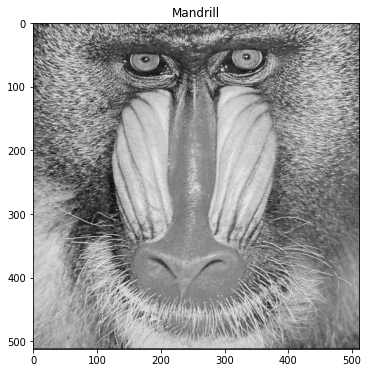

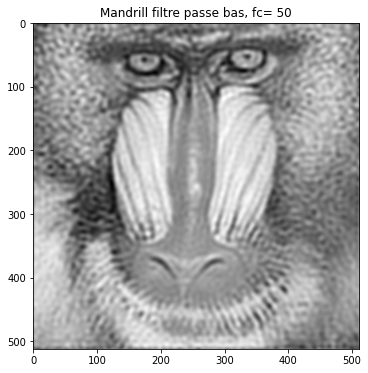

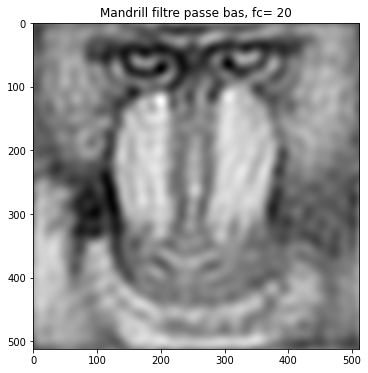

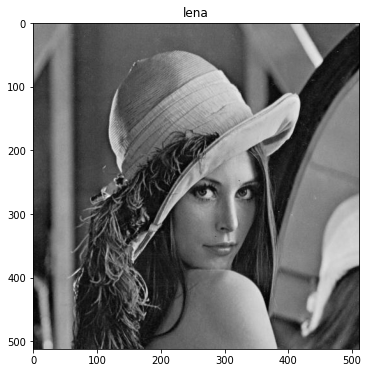

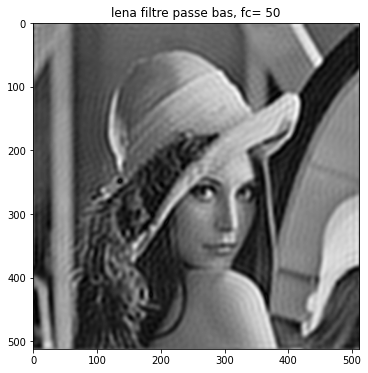

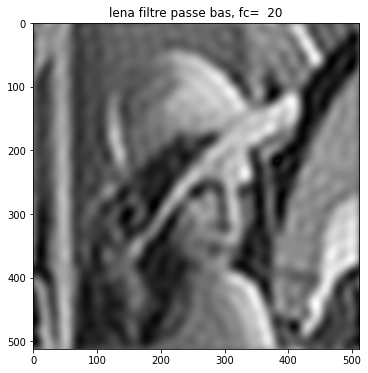

In [5]:
imshow(mandrill,"Mandrill")
imshow(lowPass(mandrill,50),"Mandrill filtre passe bas, fc= 50")
imshow(lowPass(mandrill,20),"Mandrill filtre passe bas, fc= 20")
imshow(lena,"lena")
imshow(lowPass(lena,50),"lena filtre passe bas, fc= 50")
imshow(lowPass(lena,20),"lena filtre passe bas, fc=  20")

Quand on diminue fc, l'image devient plus flou, et on peut observer un effet de "Gibbs ringing artifacts"

Cela peut servir à enlever le bruit d'une image et à appliquer le théorème de Shannon-Nyquist pour la reconstruction d'un signal grace à un échantillonnage.

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

Il faut un nombre P de  lignes et colonnes à ajouter de chaque cotés, avec P = (d-1)/2  (d etant impair)

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

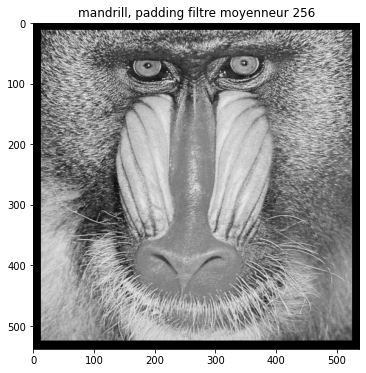

In [6]:
def imagePad(I, h):  
    """ Array*Array -> Array 
    Réalise un zéro padding d'une image
    """
    N=math.ceil((size(h[1])-1) / 2)
    x,y=I.shape
    xn=x+2*N
    yn=y+2*N
    padding=np.zeros((xn,yn))
    padding[N:xn-N,N:yn-N]=I[:,:]
    return padding

nb_F=27
imshow(imagePad(mandrill, (np.zeros((nb_F,nb_F)))),"mandrill, padding filtre moyenneur 256")

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [7]:
def conv2(I, h):
    """ Array*Array -> Array 
        retourne la convolution linéaire de image par filtre
    """
    x,y=I.shape
    fx,fy=h.shape
    d1=int((fx-1)/2)
    d2=int((fy-1)/2)
    convoluer=np.zeros((x,y))
    pad=imagePad(I,h)

    for i in range(x):
        for j in range(y):
            som=0
            for fi in range(-d1,d1+1):
                for fj in range(-d2,d2+1):
                    som+=pad[i+d1-fi,j+d2-fj]*h[d1+fi,d2+fj]
            convoluer[i,j]=som
    return convoluer


4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

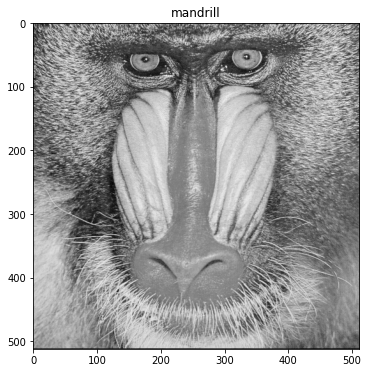

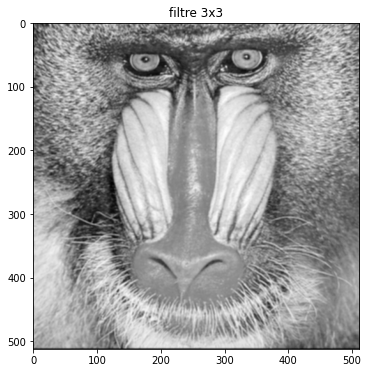

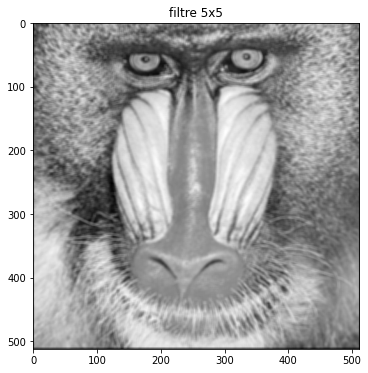

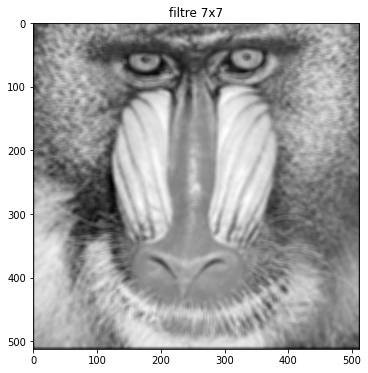

In [8]:
def filtre_moyen(N):
    """ int-> Array
    retourne le filtre Moyen de taille NxN
    """
    return (np.ones((N,N))/(N*N))

imshow(mandrill,"mandrill")
imshow(conv2(mandrill,  filtre_moyen(3)),"filtre 3x3")
imshow(conv2(mandrill,  filtre_moyen(5)),"filtre 5x5")
imshow(conv2(mandrill,  filtre_moyen(7)),"filtre 7x7")

On observe que les effets du filtre moyen varient en fonction de la taille da matrice : plus les dimensions du sont grandes, plus le bruit sera éliminé. Cependant, les détails sont eux-aussi effacés et les contours étalés.
Cet effet est dû au fait que le niveau de gris du pixel central dans l'image initiale est remplacé par la moyenne des niveaux de gris des pixels environnants. 

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

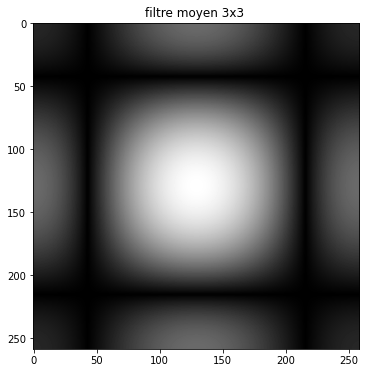

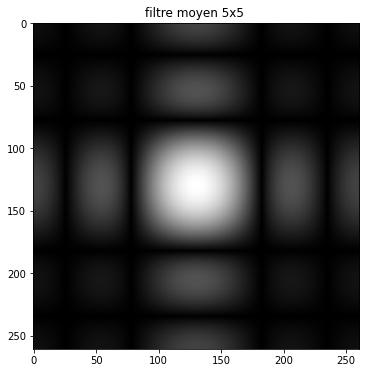

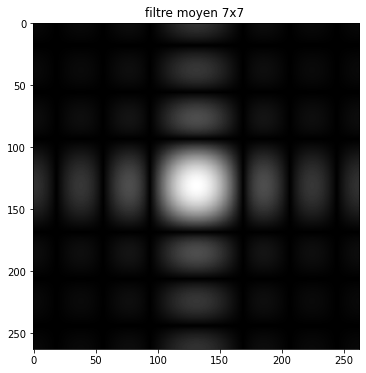

In [10]:
imshow(toVisualizeLogFT(computeFT(imagePad(filtre_moyen(3),np.zeros((256,256))))),"filtre moyen 3x3 ")
imshow(toVisualizeLogFT(computeFT(imagePad(filtre_moyen(5),np.zeros((256,256))))),"filtre moyen 5x5 ")
imshow(toVisualizeLogFT(computeFT(imagePad(filtre_moyen(7),np.zeros((256,256))))),"filtre moyen 7x7 ")

6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

$H(u,v)=\frac{1}{L^2} \sum_{k=0}^{L-1}\sum_{l=0}^{L-1} e^{-ilu-ikv}$ L taille du filtre

Un filtre passe-bas idéal doit avoir une fréquence qui vaut 0 en dehors d'un domaine défini.

Or, on peut voir que la fonction de transfert a plusieurs pics autour de celui du milieu, il n ya pas de fréquence de coupure. Ce n'est donc pas un filtre passe bas idéal.

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

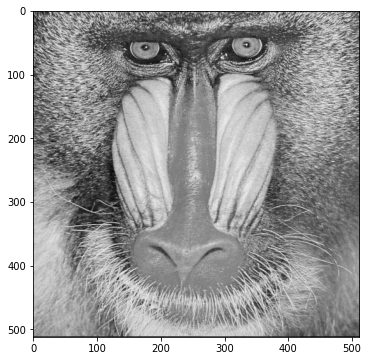

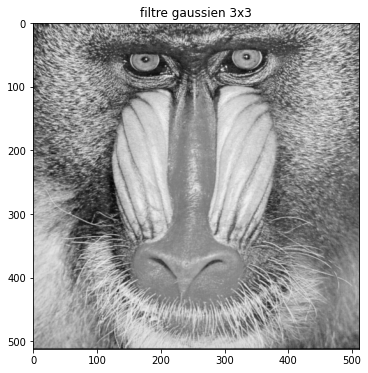

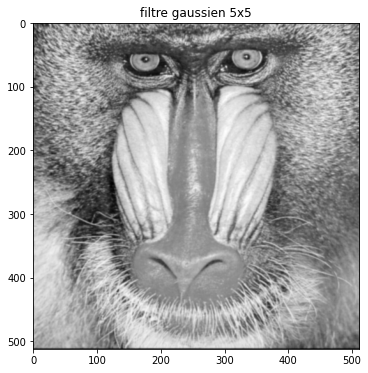

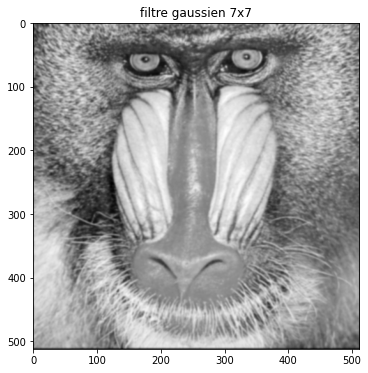

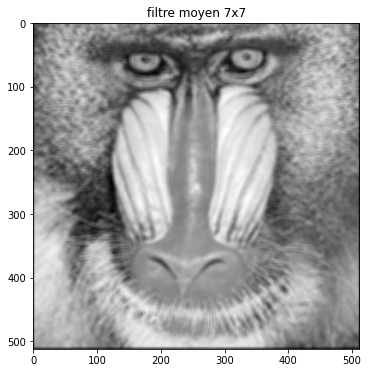

In [11]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()
### your answer start below
imshow(mandrill)

imshow(conv2(mandrill,  gaussianKernel(3/6)),"filtre gaussien 3x3")
imshow(conv2(mandrill,  gaussianKernel(5/6)),"filtre gaussien 5x5")
imshow(conv2(mandrill,  gaussianKernel((7/6))),"filtre gaussien 7x7")
imshow(conv2(mandrill,  filtre_moyen(7)),"filtre moyen 7x7")

Le filtre est de taille 3x3 quand: 2/3> sigma >=1/3 

Le filtre est de taille 5x5 quand: 1  > sigma >=2/3 

Le filtre est de taille 7x7 quand: 4/3> sigma >=1

On peut voir que contrairement au filtre moyen, avec le fitre gaussien l'image reste assez nette même avec le filtre de taille 7x7, et contrairement au filtre passe bas idéal nous n'avons pas d'effet de "ringing".

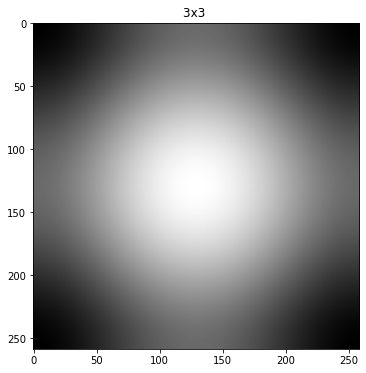

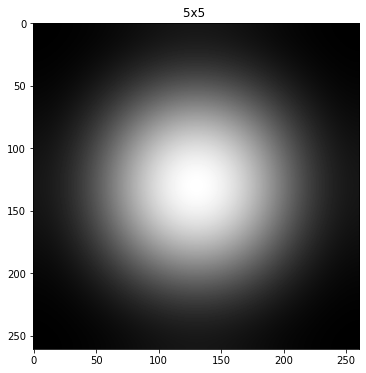

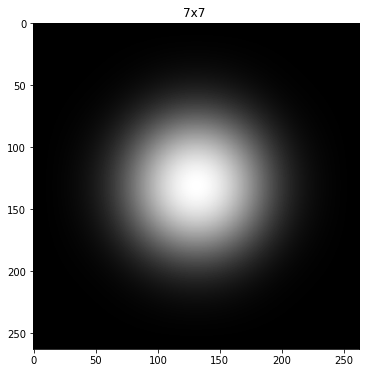

In [12]:
imshow(toVisualizeLogFT(computeFT(imagePad(gaussianKernel(3/6),np.zeros((256,256))))),"3x3 ")
imshow(toVisualizeLogFT(computeFT(imagePad(gaussianKernel(5/6),np.zeros((256,256))))),"5x5 ")
imshow(toVisualizeLogFT(computeFT(imagePad(gaussianKernel(7/6),np.zeros((256,256))))),"7x7 ")

La fonction de transfert est $H(u,v)= e^{\frac{-D^2(u,v)}{2\sigma}}$

avec $D(u,v)= \sqrt{u^2 + v^2}$

Même si cela ce rapproche plus d'un passe bas idéal que le filtre moyen, il n ya pas la non plus de fréquence de coupure.

## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

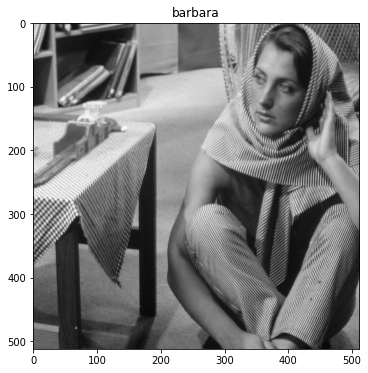

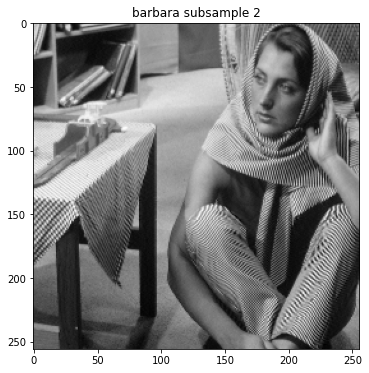

In [13]:
def subSample2(I):
    """ Array -> Array
    retourne une image à l'aquelle on a enlevé un pixel sur deux"""
    return I[::2,::2]

barbara= np.array(Image.open("img/barbara.png"))

imshow(barbara,"barbara")
imshow(subSample2(barbara),"barbara subsample 2")


2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

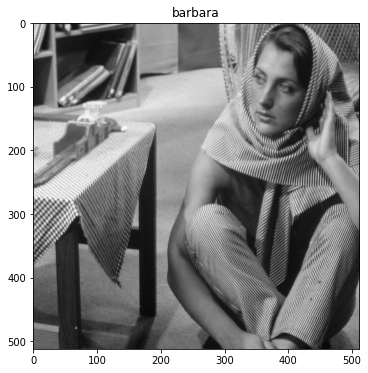

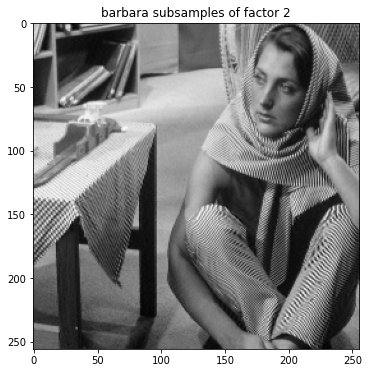

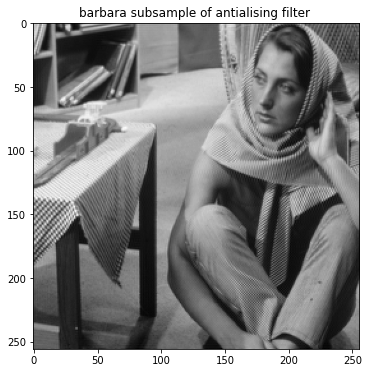

In [14]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below

def lowPassFilter(I , Filter):
    """Array*Array -> Array
    retourn une image filtré par Filter
    """
    n,m=I.shape
    If=fftshift(fft2(I))
    If = If * Filter
    If = ifft2(ifftshift(If))
    return abs(If)

nbarbara,mbarbara= barbara.shape

imshow(barbara,"barbara")
imshow(subSample2(barbara),"barbara subsamples of factor 2")
imshow(subSample2(lowPassFilter(barbara , antiAliasingFilter(nbarbara, mbarbara))),"barbara subsample of antialising filter ")
        

"As comment, recall the principle of filtering in the frequency domain."

Le filtrage sur les fréquences correspond à la suppression d'éléments ayant une faible ou grande fréquence. Ce filtrage peut permettre de lisser ou d'améliorer la qualité de l'image (Smoothing and Sharpenning). Il existe 3 filtres agissant sur les fréquences : les Low-Pass Filters, les High-Pass Filters, et les Band-Pass Filters

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

Avec la fonction subSample2, on enlève sur l'image un pixel sur deux. On observe alors que l'image obtenue est un peu plus floue ainsi que la présence de motifs qui correspondent à un pattern de moiré.
Le filtre anti-aliasing permet d'éliminer ce pattern.

## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

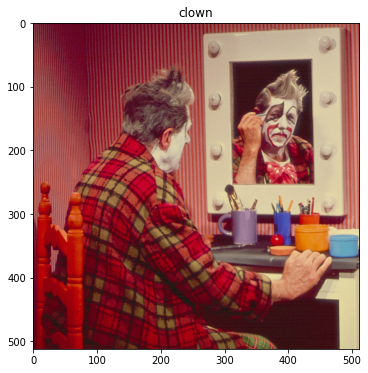

clown est de taille (512, 512, 3)


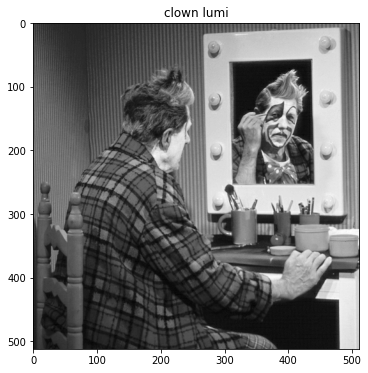

clown lumi est de taille (512, 512)


In [15]:
I1= np.array(Image.open("img/clown.bmp"))
I2= np.array(Image.open("img/clown_lumi.bmp"))
imshow(I1,"clown")
print("clown est de taille",I1.shape)
imshow(I2,"clown lumi")
print("clown lumi est de taille",I2.shape)

What difference there are between them?

L'image 1 est colorée et est représentée par une array en 3 dimensions. Alors que l'image 2 est en noire et blanc et est représentée par une array en 2 dimensions. On peut alors penser que la 3ème dimension permet de colorer l'image (cf question suivante).

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

Les 2 premières dimensions correspondent aux coordonnées x et y de l'image. La troisième, quand à elle, permet de représenter la valeur des couleurs RGB pour chaque pixel de coordonnées x, y.

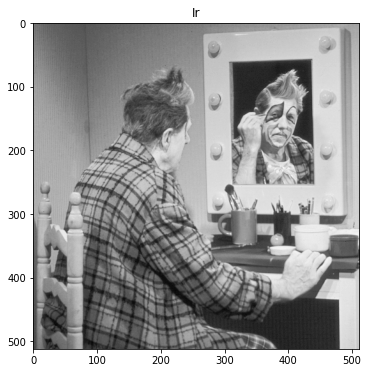

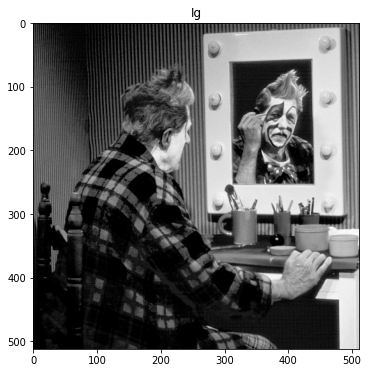

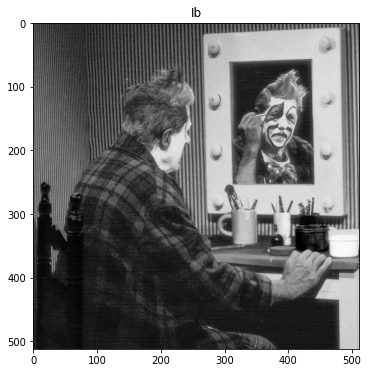

In [16]:
img_clown = Image.open("img/clown.bmp")
(Ir,Ig,Ib)= img_clown.split()
imshow(Ir,'Ir')
imshow(Ig ,'Ig')
imshow(Ib, 'Ib')

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

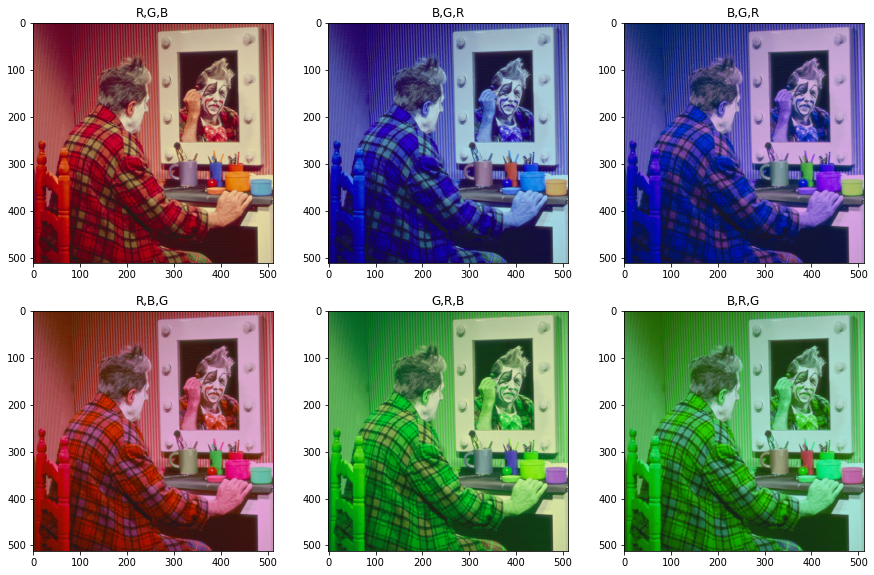

In [17]:
plt.rcParams['figure.figsize'] = [15, 15]

img_clown2=Image.new('RGB',img_clown.size)
img_clown2=Image.merge('RGB',(Ib,Ig,Ir))

img_clown3=Image.new('RGB',img_clown.size)
img_clown3=Image.merge('RGB',(Ig,Ib,Ir))

img_clown4=Image.new('RGB',img_clown.size)
img_clown4=Image.merge('RGB',(Ir,Ib,Ig))

img_clown5=Image.new('RGB',img_clown.size)
img_clown5=Image.merge('RGB',(Ig,Ir,Ib))

img_clown6=Image.new('RGB',img_clown.size)
img_clown6=Image.merge('RGB',(Ib,Ir,Ig))

plt.subplot(3,3,1)
plt.title ( "R,G,B")
plt.imshow(img_clown)

plt.subplot(3,3,2)
plt.title ( "B,G,R")
plt.imshow(img_clown2)

plt.subplot(3,3,3)
plt.title ( "B,G,R")
plt.imshow(img_clown3)

plt.subplot(3,3,4)
plt.title ( "R,B,G")
plt.imshow(img_clown4)

plt.subplot(3,3,5)
plt.title ( "G,R,B")
plt.imshow(img_clown5)

plt.subplot(3,3,6)
plt.title ( "B,R,G")
plt.imshow(img_clown6)

plt.show()


4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

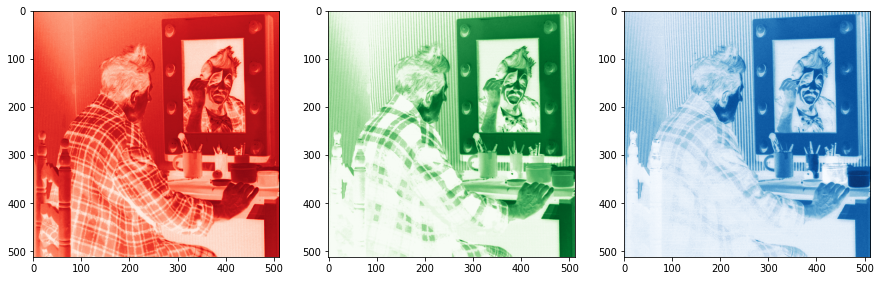

In [18]:
plt.subplot(1,3,1)
plt.imshow(Ir,cmap="Reds")
plt.subplot(1,3,2)
plt.imshow(Ig,cmap="Greens")
plt.subplot(1,3,3)
plt.imshow(Ib,cmap="Blues")
plt.show()
